# General Imports

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [4]:
from icecream import ic

In [5]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [6]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [7]:
from models import UnetSemSegModule
from dropblock import DropBlock2D

In [8]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [9]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier

## OoD/Anomaly Detection:

Steps for using the package:

1. Load you Dataloader Pytorch-Lightning Module
2. Load your trained DNN PyTorch-Lightning Module
3. Add Hook to DNN Module for MC samples extraction
4. Get Monte-Carlo (MC) samples for In-Distribution (InD) samples dataloader, and Out-of-Distribution (OoD) samples dataloader
5. Get Entropy from InD and OoD MC samples
6. Build OoD Detection dataset (with InD and OoD samples)
7. Build OoD data-driven Detector (classifier)
8. Show OoD performance results

# Datasets

## Woodscape

In [10]:
ws_dataset_path = './Data/DATASETS/WoodScape/'
batch_size = 1
img_h = 128
img_w = 256

In [11]:
ws_dm_normal_unet = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                        batch_size=batch_size,
                                        img_size=(img_h, img_w),
                                        num_workers=12,
                                        drop_last=True,
                                        default_transforms=True)
ws_dm_normal_unet.setup()

DATASET Shuffle Random SEED:  10


In [12]:
ws_unet_ws_normal_train_loader = ws_dm_normal_unet.train_dataloader()
ws_unet_ws_normal_valid_loader = ws_dm_normal_unet.val_dataloader()
ws_unet_ws_normal_test_loader = ws_dm_normal_unet.test_dataloader()

In [13]:
ws_dm_anomal_unet = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                        batch_size=batch_size,
                                        img_size=(img_h, img_w),
                                        num_workers=12,
                                        drop_last=True,
                                        default_transforms=True)
ws_dm_anomal_unet.setup()

DATASET Shuffle Random SEED:  10


In [14]:
ws_anomal_valid_loader = ws_dm_anomal_unet.anomaly_val_dataloader()
ws_anomal_test_loader = ws_dm_anomal_unet.anomaly_test_dataloader()

In [15]:
ic(len(ws_unet_ws_normal_train_loader));
ic(len(ws_unet_ws_normal_valid_loader));
ic(len(ws_unet_ws_normal_test_loader));
ic(len(ws_anomal_valid_loader));
ic(len(ws_anomal_test_loader));

ic| len(ws_unet_ws_normal_train_loader): 5929
ic| len(ws_unet_ws_normal_valid_loader): 1482
ic| len(ws_unet_ws_normal_test_loader): 823
ic| len(ws_anomal_valid_loader): 1482
ic| len(ws_anomal_test_loader): 823


## Cityscapes

In [16]:
cs_dataset_path = './Data/DATASETS/CityScapes'
batch_size = 1
img_h = 128
img_w = 256

In [17]:
cs_dm_normal_unet = CityscapesDataModule(data_dir=cs_dataset_path,
                                         batch_size=batch_size,
                                         img_size=(img_h, img_w),
                                         target_type='semantic',
                                         num_workers=12,
                                         drop_last=True,
                                         default_transforms=True,
                                         default_img_mask_transforms=False)

In [18]:
cs_train_loader = cs_dm_normal_unet.train_dataloader()
cs_valid_loader = cs_dm_normal_unet.val_dataloader()
cs_test_loader = cs_dm_normal_unet.test_dataloader()

In [19]:
ic(len(cs_train_loader))

ic| len(cs_train_loader): 2975

2975

## Woodscape-Soiling

In [20]:
ws_soil_dataset_path = "./Data/DATASETS/WoodScape/soiling_dataset/"
batch_size = 1
img_h = 128
img_w = 256

In [21]:
ws_soil_dm = WoodScapeSoilingDataModule(dataset_dir=ws_soil_dataset_path,
                                        batch_size=1,
                                        img_size=(img_h, img_w),
                                        default_transforms=True,
                                        seed=9290)
ws_soil_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [22]:
ws_soil_valid_loader = ws_soil_dm.val_dataloader()
ws_soil_test_loader = ws_soil_dm.test_dataloader()

In [23]:
ic(len(ws_soil_valid_loader))
ic(len(ws_soil_test_loader))

ic| len(ws_soil_valid_loader): 800


ic| len(ws_soil_test_loader): 1000


1000

## Dataloaders Samples

In [44]:
dataiter_ws_valid = iter(ws_unet_ws_normal_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


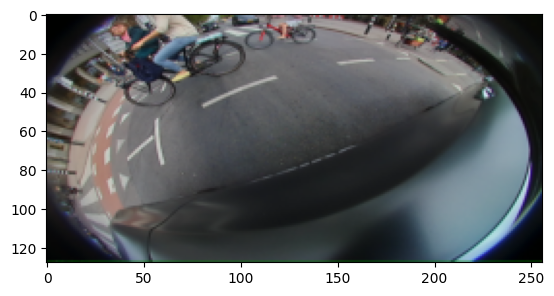

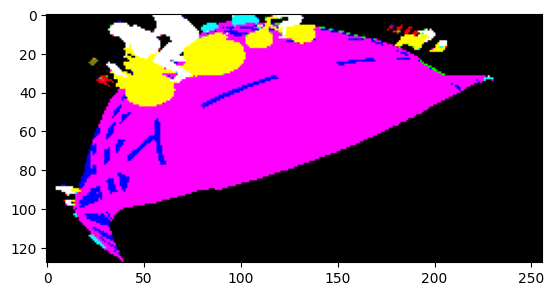

In [45]:
batch_ws_data, batch_ws_labels = dataiter_ws_valid.next()
plt.figure()
show_dataset_image(batch_ws_data[0], ws_dm_normal_unet.norm_mean, ws_dm_normal_unet.norm_std)
plt.figure()
show_dataset_mask(batch_ws_labels[0], ws_dm_normal_unet.woodscape_ds_train.decode_segmap)
plt.show()

In [50]:
dataiter_ws_anomal_valid = iter(ws_anomal_valid_loader)

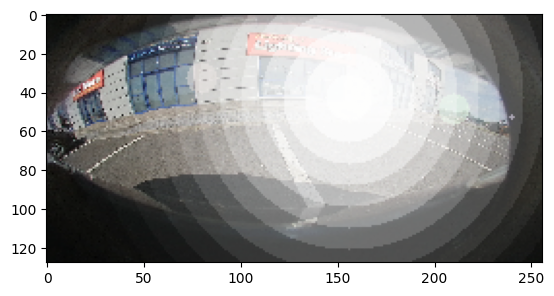

In [69]:
batch_ws_anomal_data, batch_ws_anomal_labels = dataiter_ws_anomal_valid.next()
plt.figure()
show_dataset_image(batch_ws_anomal_data[0], ws_dm_anomal_unet.norm_mean, ws_dm_anomal_unet.norm_std)
plt.show()

In [57]:
dataiter_ws_soiling_valid = iter(ws_soil_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


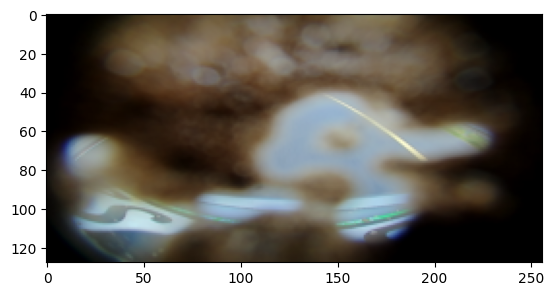

In [64]:
batch_ws_soil_data, batch_ws_soil_labels = dataiter_ws_soiling_valid.next()
plt.figure()
show_dataset_image(batch_ws_soil_data[0], ws_dm_normal_unet.norm_mean, ws_dm_normal_unet.norm_std)
plt.show()

In [65]:
dataiter_cs_valid = iter(cs_valid_loader)

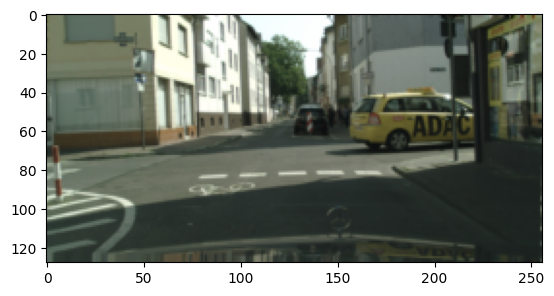

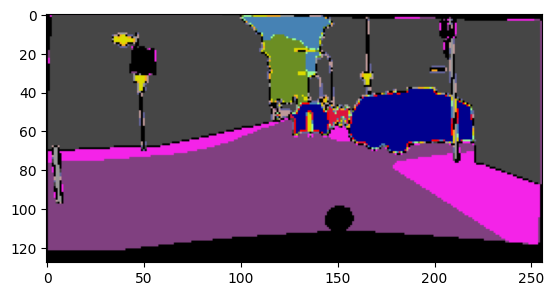

In [66]:
batch_cs_data, batch_cs_labels = dataiter_cs_valid.next()
plt.figure()
show_dataset_image(batch_cs_data[0], cs_dm_normal_unet.norm_mean, cs_dm_normal_unet.norm_std)
plt.figure()
show_dataset_mask(batch_cs_labels[0].squeeze(), cs_valid_loader.dataset.decode_target)
plt.show()

# U-Net Woodscapes Model

In [24]:
ws_unet_path = "./Projects/Semantic_Segmentation_Unet/lightning_logs/version_122246/checkpoints/last.ckpt"

ws_unet_model = UnetSemSegModule.load_from_checkpoint(checkpoint_path=ws_unet_path)

In [25]:
ic(ws_unet_model.pred_loss_type);
ic(ws_unet_model.num_classes);

ic| ws_unet_model.pred_loss_type: 'cross_entropy'


ic| ws_unet_model.num_classes: 10


In [26]:
ws_unet_model.eval();

ic(ws_unet_model.unet_model.drop_block2d_layer);
ic(ws_unet_model.unet_model.drop_block2d_layer.block_size);
ic(ws_unet_model.unet_model.drop_block2d_layer.drop_prob);
ic(ws_unet_model.unet_model.drop_block2d_layer.training);
ic(ws_unet_model.unet_model.drop_block2d_layer._forward_hooks)

ic| ws_unet_model.unet_model.drop_block2d_layer: DropBlock2D()


ic| ws_unet_model.unet_model.drop_block2d_layer.block_size: 16
ic| ws_unet_model.unet_model.drop_block2d_layer.drop_prob: 0.4
ic| ws_unet_model.unet_model.drop_block2d_layer.training: False
ic| ws_unet_model.unet_model.drop_block2d_layer._forward_hooks: OrderedDict()


OrderedDict()

# Add Hook U-Net Woodscape

In [27]:
ws_unet_hook_dropblock2d_layer = Hook(ws_unet_model.unet_model.drop_block2d_layer)

In [ ]:
ic(ws_unet_model.unet_model.drop_block2d_layer._forward_hooks);

# Get Monte Carlo Samples

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [30]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def unet_apply_dropout(m):
    if type(m) == torch.nn.Dropout or type(m) == DropBlock2D:
        m.train()

In [31]:
mc_samples = 16

In [ ]:
ws_unet_model.unet_model.to(device);
ws_unet_model.unet_model.eval(); 
ws_unet_model.unet_model.apply(unet_apply_dropout); # enable dropout

ic(ws_unet_model.unet_model.drop_block2d_layer);
ic(ws_unet_model.unet_model.drop_block2d_layer.block_size);
ic(ws_unet_model.unet_model.drop_block2d_layer.drop_prob);
ic(ws_unet_model.unet_model.drop_block2d_layer.training);
ic(ws_unet_model.unet_model.drop_block2d_layer._forward_hooks);

In [ ]:
test = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                        ws_unet_ws_normal_train_loader,
                                        mc_samples,
                                        ws_unet_hook_dropblock2d_layer,
                                        get_2d_rep_mean=True)

In [24]:
ws_unet_ws_normal_train_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                  ws_unet_ws_normal_train_loader,
                                                                  mc_samples,
                                                                  ws_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)


In [29]:
ws_unet_ws_normal_valid_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                  ws_unet_ws_normal_valid_loader,
                                                                  mc_samples,
                                                                  ws_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)

ws_unet_ws_normal_test_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                  ws_unet_ws_normal_test_loader,
                                                                  mc_samples,
                                                                  ws_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)

In [81]:
ws_unet_ws_anomal_valid_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                  ws_anomal_valid_loader,
                                                                  mc_samples,
                                                                  ws_unet_hook_dropblock2d_layer,
                                                                  get_2d_rep_mean=True)

ws_unet_ws_anomal_test_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                 ws_anomal_test_loader,
                                                                 mc_samples,
                                                                 ws_unet_hook_dropblock2d_layer,
                                                                 get_2d_rep_mean=True)

In [77]:
ws_unet_cs_valid_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                            cs_valid_loader,
                                                            mc_samples,
                                                            ws_unet_hook_dropblock2d_layer,
                                                            get_2d_rep_mean=True)

ws_unet_cs_test_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                 cs_test_loader,
                                                                 mc_samples,
                                                                 ws_unet_hook_dropblock2d_layer,
                                                                 get_2d_rep_mean=True)

In [98]:
ws_unet_ws_soil_valid_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                                ws_soil_valid_loader,
                                                                mc_samples,
                                                                ws_unet_hook_dropblock2d_layer,
                                                                get_2d_rep_mean=True)

ws_unet_ws_soil_test_16mcds = get_latent_represent_mcd_samples(ws_unet_model.unet_model,
                                                               ws_soil_test_loader,
                                                               mc_samples,
                                                               ws_unet_hook_dropblock2d_layer,
                                                               get_2d_rep_mean=True)

In [25]:
ws_unet_ws_normal_train_16mcds.shape

torch.Size([94864, 128])

In [31]:
torch.save(ws_unet_ws_normal_train_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_normal_train_16mcds.pt')

In [80]:
torch.save(ws_unet_ws_normal_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_normal_valid_16mcds.pt')
torch.save(ws_unet_ws_normal_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_normal_test_16mcds.pt')

In [82]:
torch.save(ws_unet_ws_anomal_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_anomal_valid_16mcds.pt')
torch.save(ws_unet_ws_anomal_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_anomal_test_16mcds.pt')

In [83]:
torch.save(ws_unet_cs_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_cs_valid_16mcds.pt')
torch.save(ws_unet_cs_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_cs_test_16mcds.pt')

In [99]:
torch.save(ws_unet_ws_soil_valid_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_soil_valid_16mcds.pt')
torch.save(ws_unet_ws_soil_test_16mcds,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/mc_samples/ws_unet_ws_soil_test_16mcds.pt')

# Get Entropy

In [32]:
_, ws_unet_h_z_ws_normal_train_samples_np = get_dl_h_z(ws_unet_ws_normal_train_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (5929, 1)
ic| dl_h_z_samples_np.shape: (5929, 128)


In [33]:
_, ws_unet_h_z_ws_normal_valid_samples_np = get_dl_h_z(ws_unet_ws_normal_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1482, 1)
ic| dl_h_z_samples_np.shape: (1482, 128)


In [85]:
_, ws_unet_h_z_ws_normal_test_samples_np = get_dl_h_z(ws_unet_ws_normal_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (823, 1)
ic| dl_h_z_samples_np.shape: (823, 128)


In [83]:
_, ws_unet_h_z_ws_anomal_valid_samples_np = get_dl_h_z(ws_unet_ws_anomal_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1482, 1)
ic| dl_h_z_samples_np.shape: (1482, 128)


In [84]:
_, ws_unet_h_z_ws_anomal_test_samples_np = get_dl_h_z(ws_unet_ws_anomal_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (823, 1)
ic| dl_h_z_samples_np.shape: (823, 128)


In [88]:
_, ws_unet_h_z_cs_valid_samples_np = get_dl_h_z(ws_unet_cs_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (500, 1)
ic| dl_h_z_samples_np.shape: (500, 128)


In [89]:
_, ws_unet_h_z_cs_test_samples_np = get_dl_h_z(ws_unet_cs_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1525, 1)
ic| dl_h_z_samples_np.shape: (1525, 128)


In [100]:
_, ws_unet_h_z_ws_soil_valid_samples_np = get_dl_h_z(ws_unet_ws_soil_valid_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (800, 1)
ic| dl_h_z_samples_np.shape: (800, 128)


In [101]:
_, ws_unet_h_z_ws_soil_test_samples_np = get_dl_h_z(ws_unet_ws_soil_test_16mcds, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1000, 1)
ic| dl_h_z_samples_np.shape: (1000, 128)


In [34]:
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_normal_train_samples_np',
        ws_unet_h_z_ws_normal_train_samples_np)

In [102]:
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_normal_valid_samples_np',
        ws_unet_h_z_ws_normal_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_normal_test_samples_np',
        ws_unet_h_z_ws_normal_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_anomal_valid_samples_np',
        ws_unet_h_z_ws_anomal_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_anomal_test_samples_np',
        ws_unet_h_z_ws_anomal_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_cs_valid_samples_np',
        ws_unet_h_z_cs_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_cs_test_samples_np',
        ws_unet_h_z_cs_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_soil_valid_samples_np',
        ws_unet_h_z_ws_soil_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_soil_test_samples_np',
        ws_unet_h_z_ws_soil_test_samples_np)

# Load Entropy

In [11]:
ws_unet_h_z_ws_normal_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_normal_valid_samples_np.npy')

ws_unet_h_z_ws_normal_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_normal_test_samples_np.npy')

ws_unet_h_z_ws_anomal_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_anomal_valid_samples_np.npy')

ws_unet_h_z_ws_anomal_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_anomal_test_samples_np.npy')

ws_unet_h_z_cs_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_cs_valid_samples_np.npy')

ws_unet_h_z_cs_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_cs_test_samples_np.npy')

ws_unet_h_z_ws_soil_valid_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_soil_valid_samples_np.npy')

ws_unet_h_z_ws_soil_test_samples_np = np.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/unet/embeddings/woodscape/entropy/ws_unet_h_z_ws_soil_test_samples_np.npy')

# Plot 2D Entropy Projection 

(2964, 128)
(2964, 1)
(2964, 2)


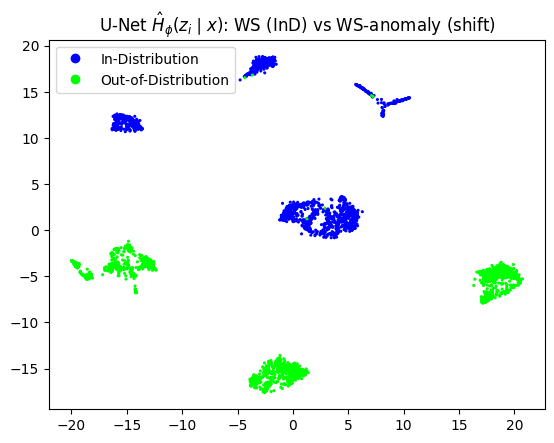

In [86]:
plot_samples_pacmap(ws_unet_h_z_ws_normal_valid_samples_np,
                    ws_unet_h_z_ws_anomal_valid_samples_np,
                    neighbors=12,
                    title="U-Net $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs WS-anomaly (shift)")

(1646, 128)
(1646, 1)
(1646, 2)


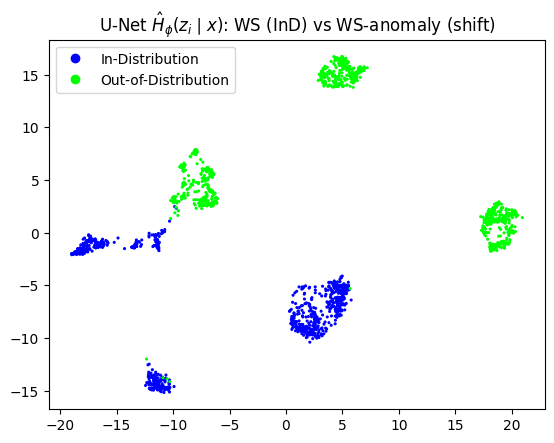

In [87]:
plot_samples_pacmap(ws_unet_h_z_ws_normal_test_samples_np,
                    ws_unet_h_z_ws_anomal_test_samples_np,
                    neighbors=12,
                    title="U-Net $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs WS-anomaly (shift)")

(1982, 128)
(1982, 1)
(1982, 2)


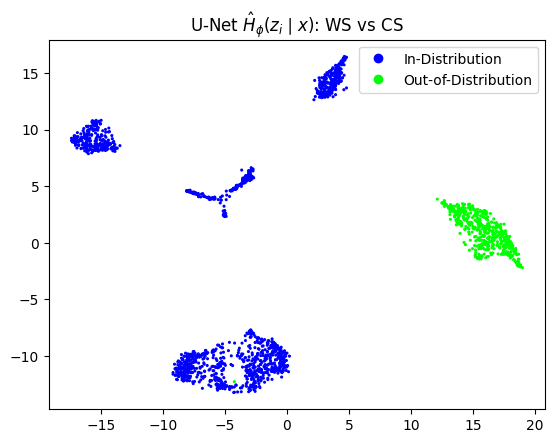

In [14]:
plot_samples_pacmap(ws_unet_h_z_ws_normal_valid_samples_np,
                    ws_unet_h_z_cs_valid_samples_np,
                    neighbors=12,
                    title="U-Net $\hat{H}_{\phi}(z_i \mid x)$: WS vs CS")

(2348, 128)
(2348, 1)
(2348, 2)


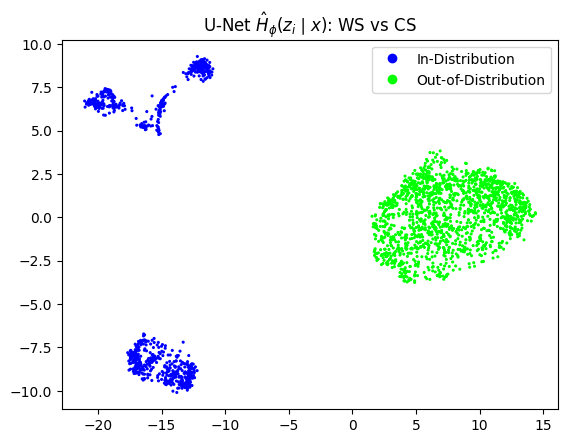

In [15]:
plot_samples_pacmap(ws_unet_h_z_ws_normal_test_samples_np,
                    ws_unet_h_z_cs_test_samples_np,
                    neighbors=12,
                    title="U-Net $\hat{H}_{\phi}(z_i \mid x)$: WS vs CS")

(2282, 128)
(2282, 1)
(2282, 2)


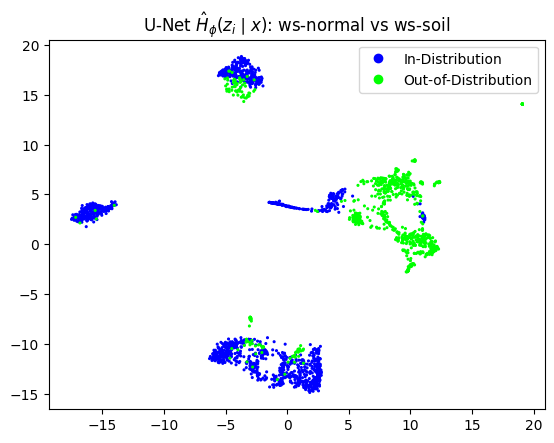

In [19]:
plot_samples_pacmap(ws_unet_h_z_ws_normal_valid_samples_np,
                    ws_unet_h_z_ws_soil_valid_samples_np,
                    neighbors=12,
                    title="U-Net $\hat{H}_{\phi}(z_i \mid x)$: ws-normal vs ws-soil")

(1823, 128)
(1823, 1)
(1823, 2)


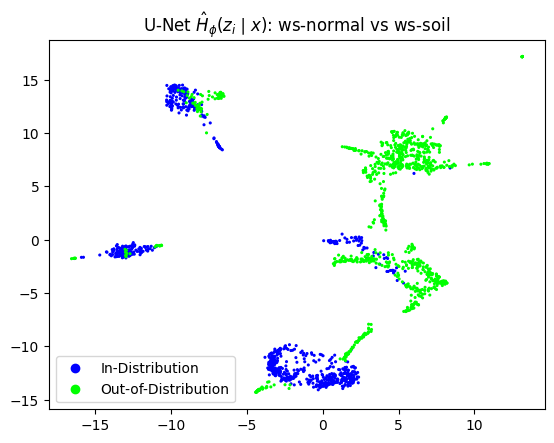

In [18]:
plot_samples_pacmap(ws_unet_h_z_ws_normal_test_samples_np,
                    ws_unet_h_z_ws_soil_test_samples_np,
                    neighbors=12,
                    title="U-Net $\hat{H}_{\phi}(z_i \mid x)$: ws-normal vs ws-soil")